In [ ]:
from google.colab import drive
drive.mount ("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os # accessing directory structure
import random
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

In [ ]:
# Replace with the path to your directory
directory_path = "/content/drive/MyDrive/Colab_Notebooks/Pothole_Image_Data"

In [ ]:
# Create empty lists to store file paths and labels
listImageFilePaths = []
listLabels = []

for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        # Check if the file is an image file
        if filename.lower().endswith(('.bmp', '.gif', '.jpeg', '.jpg', '.png')):
            # Add the file path to the list
            listImageFilePaths.append(os.path.join(dirname, filename))
            # Add the label to the list based on whether the filename contains 'pothole'
            listLabels.append('0' if 'plain' in filename.lower() else '1')

# Print the total number of images
print('Total images: ', len(listImageFilePaths), "Label length: ", len(listLabels))

Total images:  1180 Label length:  1180


In [ ]:
def displayImage(imagePath):
    image = mpimg.imread(imagePath)
    plt.imshow(image)
    print('Image path', imagePath)
    #print('Image size -', image.shape)
    plt.show()

In [ ]:
def displayRandomImages(listImageFilePaths, nImageToDisplay):
    listImageIndex = random.sample(range(0, len(listImageFilePaths)), nImageToDisplay)
    
    for imageIndex in listImageIndex:
        displayImage(listImageFilePaths[imageIndex])
        print("Label: ", listLabels[imageIndex])

In [ ]:
type(listImageFilePaths[0])

str

Image path /content/drive/MyDrive/Colab_Notebooks/Pothole_Image_Data/143.jpg


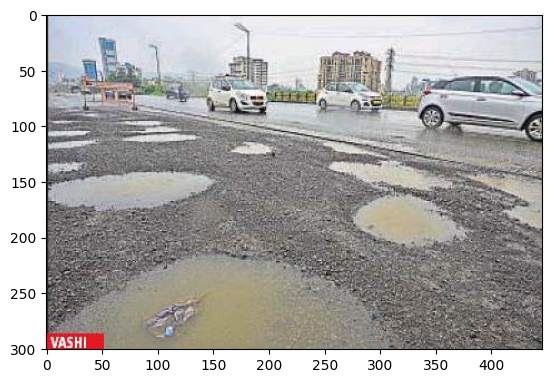

Label:  1
Image path /content/drive/MyDrive/Colab_Notebooks/Pothole_Image_Data/222.jpg


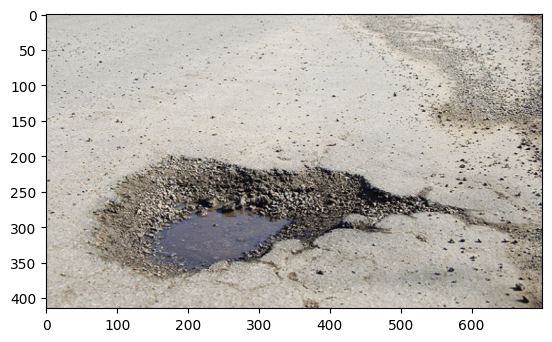

Label:  1
Image path /content/drive/MyDrive/Colab_Notebooks/Pothole_Image_Data/254.jpg


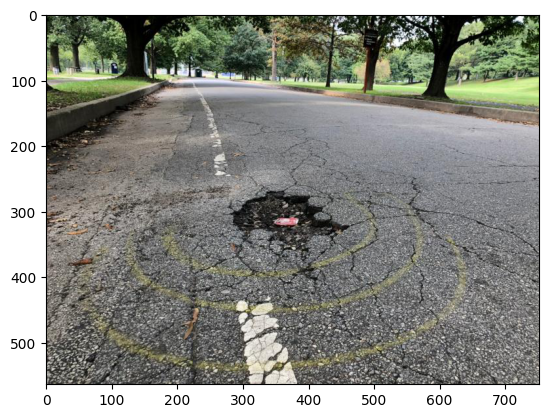

Label:  1
Image path /content/drive/MyDrive/Colab_Notebooks/Pothole_Image_Data/483.jpg


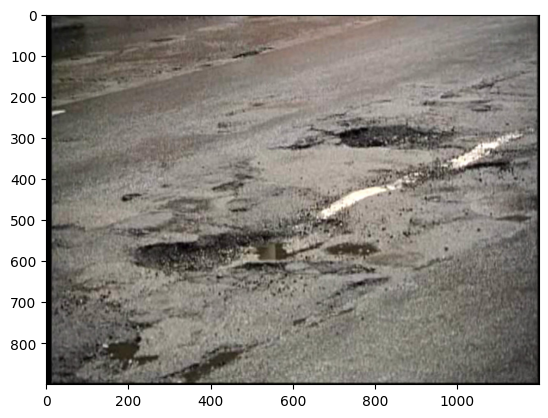

Label:  1
Image path /content/drive/MyDrive/Colab_Notebooks/Pothole_Image_Data/Plain1122.jpg


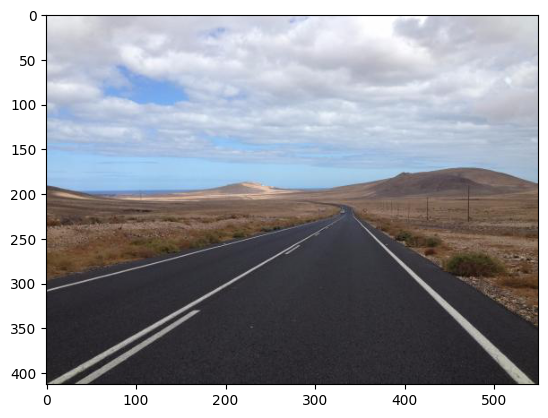

Label:  0


In [ ]:
displayRandomImages(listImageFilePaths, nImageToDisplay = 5)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# set the input size of the images
input_size = (224, 224)
batch_size = 32
num_classes = 2

In [ ]:
# load the pre-trained model (VGG16 in this case) without the fully-connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_size[0], input_size[1], 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# add your own fully-connected layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
# define the new model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# freeze the weights of the base model so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# compile the model with a binary cross-entropy loss and an SGD optimizer with a low learning rate
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])

In [ ]:
# set up the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
from sklearn.model_selection import train_test_split

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(listImageFilePaths, listLabels, test_size=0.2, random_state=42)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': train_image_paths, 'label': train_labels}),
    x_col='filepath',
    y_col='label',
    target_size=input_size,
    batch_size=batch_size,
    class_mode='binary')


valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': valid_image_paths, 'label': valid_labels}),
    x_col='filepath',
    y_col='label',
    target_size=input_size,
    batch_size=batch_size,
    class_mode='binary')

Found 944 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.


In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")

In [ ]:
# train the model for a few epochs
model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))

<ipython-input-20-0927415bc783>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))


Epoch 1/10
30/30 [==============================] - 64s 2s/step - loss: 0.6428 - accuracy: 0.6727 - val_loss: 0.3903 - val_accuracy: 0.7712
Epoch 2/10
30/30 [==============================] - 40s 1s/step - loss: 0.4246 - accuracy: 0.8178 - val_loss: 0.3087 - val_accuracy: 0.9746
Epoch 3/10
30/30 [==============================] - 34s 1s/step - loss: 0.3536 - accuracy: 0.8845 - val_loss: 0.2232 - val_accuracy: 0.9492
Epoch 4/10
30/30 [==============================] - 34s 1s/step - loss: 0.2947 - accuracy: 0.8983 - val_loss: 0.1933 - val_accuracy: 0.9788
Epoch 5/10
30/30 [==============================] - 34s 1s/step - loss: 0.2744 - accuracy: 0.9110 - val_loss: 0.1672 - val_accuracy: 0.9576
Epoch 6/10
30/30 [==============================] - 33s 1s/step - loss: 0.2408 - accuracy: 0.9195 - val_loss: 0.1514 - val_accuracy: 0.9788
Epoch 7/10
30/30 [==============================] - 33s 1s/step - loss: 0.2158 - accuracy: 0.9333 - val_loss: 0.1412 - val_accuracy: 0.9788
Epoch 8/10
30/30 [==

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/Model')